## Import Packages and Functionss

In [1]:
%matplotlib inline

import cv2
import gdown
import matplotlib.pyplot as plt
import os
import torch
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset
from torchsummary import summary
# from utils_cs import predict_image_mask_miou

import os
import glob

import cv2
import torch
import numpy as np
import albumentations as alb

from functools import lru_cache
from torch.utils.data import Dataset
from typing import List, Tuple, Optional

import numpy as np
import torch # torch >= 1.7.1
import torch.nn.functional as F
from torchvision import transforms as T
from tqdm import tqdm


def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        dice_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = (
                    torch.logical_and(true_class, true_label).sum().float().item()
                )
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                dice = (2 * intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
                dice_per_class.append(dice)
        return np.nanmean(iou_per_class), np.nanmean(dice_per_class)


def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def predict_image_mask_miou(
    model,
    image,
    mask,
    mean=[0.60258, 0.44218, 0.57057],
    std=[0.30052, 0.27571, 0.27647],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score


def predict_image_mask_pixel(
    model,
    image,
    mask,
    mean=[0.60258, 0.44218, 0.57057],
    std=[0.30052, 0.27571, 0.27647],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc


def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou


def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

## Check Train Image

In [2]:
path = "./dataset/patches-512/test/"

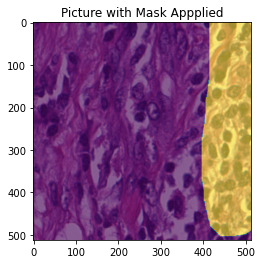

In [3]:
IMAGE_PATH = path + "images/TCGA-A2-A0D0-DX1_xmin68482_ymin39071_MPP-0.2300_105.png"
MASK_PATH = path + "masks/TCGA-A2-A0D0-DX1_xmin68482_ymin39071_MPP-0.2300_105.png" 

img = Image.open(IMAGE_PATH)
mask = Image.open(MASK_PATH)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()
# plt.savefig("picture_with_mask.png")

## Load Test Dataset

In [4]:
class CrowdsourcingTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx], 0)
        img = Image.fromarray(img)
        mask = torch.from_numpy(mask).long()  # to tensor
        return img, mask

TEST_IMAGE_PATH = path + "images/"
TEST_MASK_PATH = path + "masks/"
X_test = os.listdir(TEST_IMAGE_PATH)

test_set = CrowdsourcingTestDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, X_test)
print(len(test_set))

4039


# TransUNet

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transunet = VisionTransformerTransUNet(config_vit, img_size=512, num_classes=6)

In [7]:
checkpoint = torch.load("checkpoints_TU/epoch=53-valid_dice=0.66.ckpt")
state_dict = checkpoint['state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[6:] # remove 'module.' of dataparallel
    new_state_dict[name] = v

transunet.load_state_dict(new_state_dict)

<All keys matched successfully>

# UNet

In [8]:
unet = smp.Unet('mobilenet_v2', 
                        encoder_weights='imagenet', 
                        classes=6, 
                        activation=None, 
                        encoder_depth=5, 
                        decoder_channels=[256, 128, 64, 32, 16])

In [9]:
# unet = torch.load("checkpoints/epoch=87-valid_dice=0.65.ckpt")
checkpoint = torch.load("checkpoints/epoch=87-valid_dice=0.65.ckpt")
state_dict = checkpoint['state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[6:] # remove 'model.' of dataparallel
    new_state_dict[name] = v

unet.load_state_dict(new_state_dict)
# unet.eval()

<All keys matched successfully>

# Ours

In [143]:
url = "https://drive.google.com/uc?id=1grwgPtYKqhMrZrAHoNIXe6c4O1xgI8u5&export=download"
gdown.download(url, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1grwgPtYKqhMrZrAHoNIXe6c4O1xgI8u5&export=download
To: /home/ec2-user/SageMaker/project/github/best-patch16-transformer.ckpt
1.21GB [00:25, 47.1MB/s]


'best-patch16-transformer.ckpt'

In [24]:
!pip install git+https://github.com/rwightman/pytorch-image-models

  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-bewn88ga
  Running command git clone -q https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-bewn88ga


In [11]:
import timm
timm.__version__

'0.4.11'

In [12]:
import torch
 
from collections import OrderedDict
from models.transformer.vit import ViTForSegmentation
 
class Args:
    model_name='vit_base_patch16_224'
    image_size=(512,512)
    patch_size=(16,16)
    drop_rate=0.0
    attention_drop_rate=0.0
    pretrained=False
    head_type='transformer'
    num_layers=2
    hidden_dim=3072
    num_heads=12
    num_classes=6

model_state_dict = torch.load('best-patch16-transformer.ckpt', map_location='cpu')['state_dict']
 
# The loaded state_dict has model. in front of parameters
new_dict = OrderedDict()
for k,v in model_state_dict.items():
    new_k = k.replace('model.', '')
    new_dict[new_k] = v

args = Args
ours = ViTForSegmentation(args)
ours.load_state_dict(new_dict)

<All keys matched successfully>

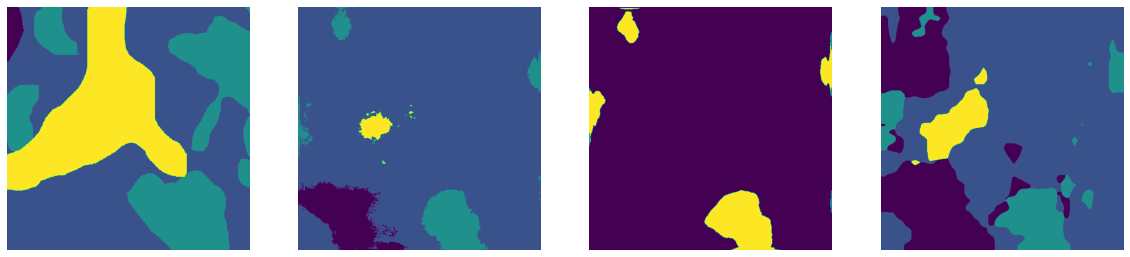

In [65]:
# test = [99, 509, 4012, 4011, 1234, 3494]
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transunet.eval()
ours.eval()
unet.eval()
image, mask = test_set[2877]
pred_mask, score = predict_image_mask_miou(transunet, image, mask, mean=mean, std=std)
pred_mask_unet, score_unet = predict_image_mask_miou(unet, image, mask, mean=mean, std=std)
pred_mask_ours, score_ours = predict_image_mask_miou(ours, image, mask, mean=mean, std=std)

fig, (ax2, ax3, ax4, ax5) = plt.subplots(1,4, figsize=(20,10))
# ax1.imshow(image)
# ax1.set_title("Picture");

ax2.imshow(mask)
# ax2.set_title("Ground Truth")
ax2.set_axis_off()

ax3.imshow(pred_mask_unet)
# ax3.set_title("{} | mIoU {:.3f}".format("UNet-MV2", score_unet[0]))
ax3.set_axis_off()

ax4.imshow(pred_mask)
# ax4.set_title("{} | mIoU {:.3f}".format("TransUNet", score[0]))
ax4.set_axis_off()

ax5.imshow(pred_mask_ours)
# ax5.set_title("{} | mIoU {:.3f}".format("Ours", score_ours[0]))
ax5.set_axis_off()

# plt.savefig("2877.png")

# TransUNet

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math

from os.path import join as pjoin

import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

logger = logging.getLogger(__name__)

import os
from re import M
import yaml
import wandb
import torch
import pytorch_lightning as pl
import albumentations as alb

from einops import rearrange

from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

from torchmetrics import MetricCollection, ConfusionMatrix

from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from simple_parsing import ArgumentParser

# from models.transformer import ViTForSegmentation ## I dont need this because i use unet

# from arguments import SegmentationArgs
from metrics import compute_accuracy, compute_dice, compute_miou
from loader import CrowdsourcingDataset, SegmentationBatchCollector

## yh
import segmentation_models_pytorch as smp 

## yh transunet
import ml_collections
from vit_seg_modeling_resnet_skip import ResNetV2

def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = './ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config

def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = './R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config




ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:   # ResNet
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])  
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features


class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3-i]=0

        else:
            skip_channels=[0,0,0,0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


class VisionTransformerTransUNet(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformerTransUNet, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

# CONFIGS = {
#     'R50-ViT-B_16': get_r50_b16_config()
# }

config_vit = get_r50_b16_config()
config_vit.n_classes = 6
config_vit.n_skip = 3
config_vit.patches.grid = (int(512 / 16), int(512 / 16))

print(config_vit)

activation: softmax
classifier: seg
decoder_channels: !!python/tuple
- 256
- 128
- 64
- 16
hidden_size: 768
n_classes: 6
n_skip: 3
patch_size: 16
patches:
  grid: !!python/tuple
  - 32
  - 32
  size: !!python/tuple
  - 16
  - 16
pretrained_path: ./R50+ViT-B_16.npz
representation_size: null
resnet:
  num_layers: !!python/tuple
  - 3
  - 4
  - 9
  width_factor: 1
resnet_pretrained_path: null
skip_channels:
- 512
- 256
- 64
- 16
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

